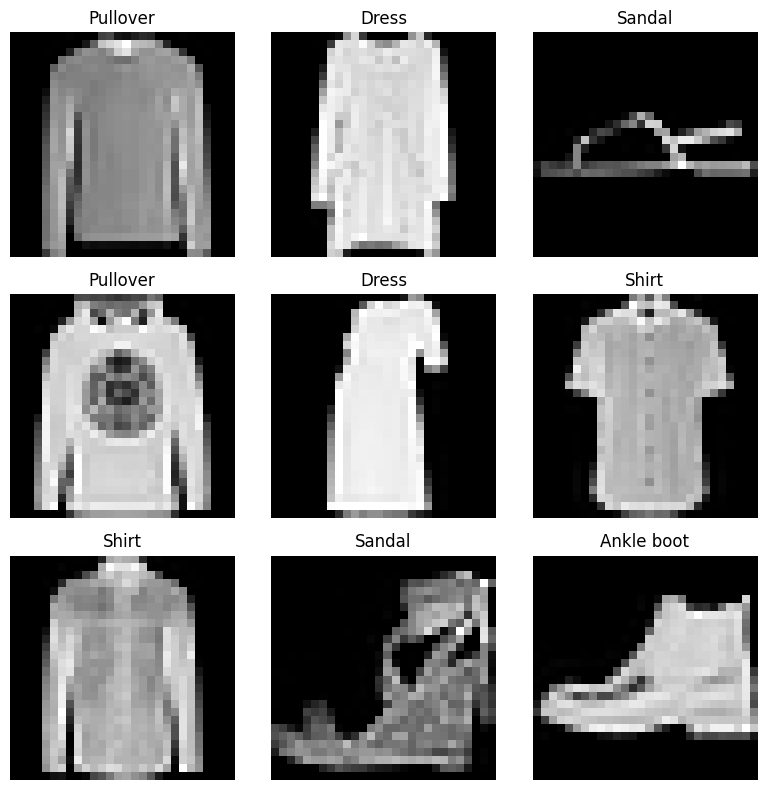


Train set:
6000 images in class T-shirt/top
6000 images in class Trouser
6000 images in class Pullover
6000 images in class Dress
6000 images in class Coat
6000 images in class Sandal
6000 images in class Shirt
6000 images in class Sneaker
6000 images in class Bag
6000 images in class Ankle boot

Test set:
1000 images in class T-shirt/top
1000 images in class Trouser
1000 images in class Pullover
1000 images in class Dress
1000 images in class Coat
1000 images in class Sandal
1000 images in class Shirt
1000 images in class Sneaker
1000 images in class Bag
1000 images in class Ankle boot

Sample 0: Correctly classified as Ankle boot
Sample 1: Correctly classified as Pullover
Sample 2: Correctly classified as Trouser
Sample 3: Correctly classified as Trouser
Sample 4: Correctly classified as Shirt
Sample 5: Correctly classified as Trouser
Sample 6: Correctly classified as Coat
Sample 7: Correctly classified as Shirt
Sample 8: Correctly classified as Sandal
Sample 9: Correctly classified

In [20]:
'''
The following code for downloading, importing and displaying the Fashion MNIST dataset is adapted
from ChatGPT, accessed February 27, 2024
'''
import numpy as np
from matplotlib import pyplot as plt
import requests
import gzip
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def download_fashion_mnist(url, file_name):
    # Check if file already exists
    if not os.path.exists(file_name):
        # Download the file
        r = requests.get(url)
        with open(file_name, 'wb') as f:
            f.write(r.content)

def load_fashion_mnist(image_file, label_file):
    # Read image file
    with gzip.open(image_file, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    # Read label file
    with gzip.open(label_file, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    return images, labels

def show_random_images(images, labels, class_names, num_images=9):
    plt.figure(figsize=(8, 8))
    
    indices = np.random.choice(len(images), num_images, replace=False)  # Select random indices
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
        plt.imshow(images[idx], cmap='gray')  # Display the image
        plt.title(class_names[labels[idx]])  # Set the title as the class name
        plt.axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

def classify_images( image_labels, class_names ):
    class_dict = dict.fromkeys( class_names, 0 )

    for idx in image_labels:
        class_dict[class_names[idx]] += 1

    for key in class_dict:
        print(f"{class_dict[key]} images in class {key}")

    return class_dict
    

def compute_accuracy( test_pairs, num_classes ):
    correct_predictions = sum(1 for pred, actual in test_pairs if pred == actual)
    total_predictions = len(test_pairs)
    
    if total_predictions == 0:
        return 0.0  # Avoid division by zero
    
    return correct_predictions / total_predictions

def compute_per_class_accuracy( test_pairs, num_classes ):
    per_class_acc_dict = {i: [0,0] for i in range(num_classes)}
    per_class_acc = []
    for pred, actual in test_pairs:
        if pred == actual:
            per_class_acc_dict[pred][0] += 1 # Correct prediction count per class
        per_class_acc_dict[pred][1] += 1 # Counting total number of predictions for this class
    
    for key in per_class_acc_dict:
        per_class_acc.append( per_class_acc_dict[key][0]/per_class_acc_dict[key][1] if per_class_acc_dict[key][1] > 0 else 0)
    
    return per_class_acc

def compute_confusion_matrix( test_pairs, num_classes ):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    for pred, acc in test_pairs:
        cm[pred][acc] += 1

    return cm

def tune_classifier( train_vectors, train_labels ):
    # Split training data into 59,000 for training and 1,000 for validation
    train_vectors, val_vectors, train_labels, val_labels = train_test_split(train_vectors.reshape(len(train_vectors), -1), train_labels, test_size=1000/60000, random_state=42)

    k_values = [1, 3, 5, 7, 10, 15]
    weight_options = ['uniform', 'distance']

    best_acc = 0
    best_params = {}

    # Iterate over parameter combinations
    for k in k_values:
        for weight in weight_options:
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
            knn.fit(train_vectors, train_labels)
            accuracy = knn.score(val_vectors, val_labels)
            
            print(f"k={k}, weights='{weight}' -> Accuracy: {accuracy:.4f}")
            
            if accuracy > best_acc:
                best_acc = accuracy
                best_params = {'k': k, 'weights': weight}

    # Output the best parameter set
    print("\nBest parameters:", best_params)

    # Train final model with best parameters
    final_knn = KNeighborsClassifier(n_neighbors=best_params['k'], weights=best_params['weights'])
    final_knn.fit(train_vectors, train_labels)

    # Evaluate on test set
    test_accuracy = final_knn.score(test_vectors, test_labels)
    print(f"Test set accuracy with best parameters: {test_accuracy:.4f}")

    return final_knn, val_vectors, val_labels

def tune_classifier_with_pca(train_vectors, train_labels, test_vectors, test_labels):
    # Define hyperparameter values to test
    k_values = [1, 3, 5, 7, 10, 15]
    weight_options = ['uniform', 'distance']
    m_values = [50, 100, 150]  # Number of principal components to test
    
    best_acc = 0
    best_params = {}
    
    original_train_vectors = train_vectors.copy()
    original_train_labels = train_labels.copy()

    for m in m_values:
        train_vectors = original_train_vectors.copy()
        train_labels = original_train_labels.copy() 

        print(f"\nRunning PCA with {m} components...")
        
        # Apply PCA
        pca = PCA(n_components=m)
        train_pca = pca.fit_transform(train_vectors)
        test_pca = pca.transform(test_vectors)
        
        # print("Before train_test_split:")
        # print("train_pca shape:", train_pca.shape)  
        # print("train_labels shape:", len(train_labels))  

        # Split training data into training and validation sets
        train_pca, val_pca, train_labels, val_labels = train_test_split(
            train_pca, train_labels, test_size=1000/60000, random_state=42)
        
        
        # print("After train_test_split:")
        # print("train_pca shape:", train_pca.shape)  
        # print("train_labels shape:", len(train_labels)) 

        # Iterate over k and weight parameters
        for k in k_values:
            for weight in weight_options:
                knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
                knn.fit(train_pca, train_labels)
                accuracy = knn.score(val_pca, val_labels)
                
                print(f"m={m}, k={k}, weights='{weight}' -> Accuracy: {accuracy:.4f}")
                
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_params = {'m': m, 'k': k, 'weights': weight}
    
    # Output the best parameter set
    print("\nBest parameters:", best_params)
    train_vectors = original_train_vectors.copy()
    train_labels = original_train_labels.copy()  # Ensure labels remain consistent
    
    # Train final model with best parameters
    final_pca = PCA(n_components=best_params['m'])
    train_pca = final_pca.fit_transform(train_vectors)
    test_pca = final_pca.transform(test_vectors)
    
    final_knn = KNeighborsClassifier(n_neighbors=best_params['k'], weights=best_params['weights'])
    final_knn.fit(train_pca, train_labels)

    # Evaluate on test set
    test_predictions = final_knn.predict(test_pca)

    # Compute overall accuracy
    test_accuracy = np.mean(test_predictions == test_labels)
    print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

    # Compute per-class accuracy
    num_classes = len(set(test_labels))
    per_class_correct = np.zeros(num_classes)
    per_class_total = np.zeros(num_classes)

    for pred, actual in zip(test_predictions, test_labels):
        if pred == actual:
            per_class_correct[actual] += 1
        per_class_total[actual] += 1

    per_class_accuracy = per_class_correct / per_class_total

    print("\nPer-Class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"Class {i} ({class_names[i]}): {acc:.4f}")

    # Compute confusion matrix
    cm = compute_confusion_matrix(zip(test_predictions, test_labels), num_classes)
    print("\nConfusion Matrix:\n")

    # Print header row with class names
    header = " " * 15 + "  ".join(f"{name:>15}" for name in class_names)
    print(header)
    print("-" * len(header))  # Separator line

    # Print matrix rows with class labels
    for i in range(num_classes):
        row_values = "  ".join(f"{cm[i, j]:>15}" for j in range(num_classes))
        print(f"{class_names[i]:<15} | {row_values}")

    return

# URLs for Fashion MNIST dataset
image_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz'
label_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz'

# File names to save the downloaded files
image_file = 'train-images-idx3-ubyte.gz'
label_file = 'train-labels-idx1-ubyte.gz'

# Download Fashion MNIST dataset
download_fashion_mnist(image_url, image_file)
download_fashion_mnist(label_url, label_file)

# Load Fashion MNIST dataset
train_images, train_labels = load_fashion_mnist(image_file, label_file)

# URLs for Fashion MNIST test dataset
test_image_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz'
test_label_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz'

# File names to save the downloaded files for test dataset
test_image_file = 't10k-images-idx3-ubyte.gz'
test_label_file = 't10k-labels-idx1-ubyte.gz'

# Download Fashion MNIST dataset
download_fashion_mnist(test_image_url, test_image_file)
download_fashion_mnist(test_label_url, test_label_file)

# Load Fashion MNIST dataset
test_images, test_labels = load_fashion_mnist(test_image_file, test_label_file)

# Class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

show_random_images(train_images, train_labels, class_names)

print("\nTrain set:")
train_counts = classify_images( train_labels, class_names )

print("\nTest set:")
test_counts = classify_images( test_labels, class_names )

train_vectors = np.array( [ img.ravel() for img in train_images] )
test_vectors = np.array( [ img.ravel() for img in test_images] )

train_vectors = (train_vectors - np.mean(train_vectors, axis=1, keepdims=True)) / np.std(train_vectors, axis=1, keepdims=True)
test_vectors = (test_vectors - np.mean(test_vectors, axis=1, keepdims=True)) / np.std(test_vectors, axis=1, keepdims=True)

sample_size = 25
knn = KNeighborsClassifier(n_neighbors = sample_size)
knn.fit( train_vectors, train_labels )

predictions = knn.predict( test_vectors )

print()

for i in range( sample_size ):
    predicted_label = predictions[i]
    true_label = test_labels[i]
    
    if predicted_label == true_label:
        print(f"Sample {i}: Correctly classified as {class_names[predicted_label]}")
    else:
        print(f"Sample {i}: Misclassified as {class_names[predicted_label]} (Correct: {class_names[true_label]})")


''' TEST AND METRICS OUTPUT '''

num_classes = 10
actual_test_pairs = list(zip(predictions, test_labels))

accuracy = compute_accuracy(actual_test_pairs, num_classes)  # Since Fashion MNIST has 10 classes
print(f'\nClassifier accuracy on test set: {accuracy:.2f}\n')

per_class_accuracy = compute_per_class_accuracy(actual_test_pairs, num_classes)
print()
print('\nPer class accuracy')
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i} {class_names[i]}: {acc:.4f}")


print()

cm = compute_confusion_matrix(actual_test_pairs, num_classes)
print("\nConfusion Matrix:\n")

# Print header row with class names
header = " " * 15 + "  ".join(f"{name:>15}" for name in class_names)
print(header)
print("-" * len(header))  # Separator line

# Print matrix rows with class labels
for i in range(num_classes):
    row_values = "  ".join(f"{cm[i, j]:>15}" for j in range(num_classes))
    print(f"{class_names[i]:<15} | {row_values}")
print()

best_classifier, val_vectors, val_labels = tune_classifier( train_vectors, train_labels )

# Concatenate the training and validation sets
all_vectors = np.concatenate((train_vectors, val_vectors), axis=0)
all_labels = np.concatenate((train_labels, val_labels), axis=0)

# Predict on all 60,000 images
all_predictions = best_classifier.predict(all_vectors)

# Compute overall accuracy
all_accuracy = np.mean(all_predictions == all_labels)
print(f"Overall accuracy on 60,000 images: {all_accuracy:.4f}")

# Compute per-class accuracy
num_classes = len(set(all_labels))
per_class_correct = np.zeros(num_classes)
per_class_total = np.zeros(num_classes)

for pred, actual in zip(all_predictions, all_labels):
    if pred == actual:
        per_class_correct[actual] += 1
    per_class_total[actual] += 1

per_class_accuracy = per_class_correct / per_class_total
print("\nPer-class accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i} {class_names[i]}: {acc:.4f}")

# Compute confusion matrix
actual_test_pairs = list(zip(all_predictions, all_labels))
cm = compute_confusion_matrix(actual_test_pairs, num_classes)
print("\nConfusion Matrix:\n")

# Print header row with class names
header = " " * 15 + "  ".join(f"{name:>15}" for name in class_names)
print(header)
print("-" * len(header))  # Separator line

# Print matrix rows with class labels
for i in range(num_classes):
    row_values = "  ".join(f"{cm[i, j]:>15}" for j in range(num_classes))
    print(f"{class_names[i]:<15} | {row_values}")



In [21]:
# EXTRA CREDIT: Tuning with PCA
tune_classifier_with_pca(train_vectors, train_labels, test_vectors, test_labels)



Running PCA with 50 components...
m=50, k=1, weights='uniform' -> Accuracy: 0.8590
m=50, k=1, weights='distance' -> Accuracy: 0.8590
m=50, k=3, weights='uniform' -> Accuracy: 0.8690
m=50, k=3, weights='distance' -> Accuracy: 0.8720
m=50, k=5, weights='uniform' -> Accuracy: 0.8860
m=50, k=5, weights='distance' -> Accuracy: 0.8830
m=50, k=7, weights='uniform' -> Accuracy: 0.8850
m=50, k=7, weights='distance' -> Accuracy: 0.8840
m=50, k=10, weights='uniform' -> Accuracy: 0.8740
m=50, k=10, weights='distance' -> Accuracy: 0.8770
m=50, k=15, weights='uniform' -> Accuracy: 0.8800
m=50, k=15, weights='distance' -> Accuracy: 0.8810

Running PCA with 100 components...
m=100, k=1, weights='uniform' -> Accuracy: 0.8620
m=100, k=1, weights='distance' -> Accuracy: 0.8620
m=100, k=3, weights='uniform' -> Accuracy: 0.8770
m=100, k=3, weights='distance' -> Accuracy: 0.8800
m=100, k=5, weights='uniform' -> Accuracy: 0.8870
m=100, k=5, weights='distance' -> Accuracy: 0.8930
m=100, k=7, weights='uniform

In [22]:
'''
Test code for error metrics. Leave this unchanged.
'''
test_pairs = [
    (1, 1),
    (1, 4),
    (0, 0),
    (0, 2),
    (3, 1),
    (4, 2),
    (4, 4),
    (2, 2),
    (2, 2),
    (3, 3),
    (4, 0),
    (4, 4),
    (1, 1),
    (0, 0),
    (0, 2),
    (1, 4),
    (1, 1),
    (0, 0),
    (0, 1),
    (2, 3),
]

num_classes = 5
accuracy = compute_accuracy(test_pairs, num_classes)
print(f'accuracy: {accuracy:.2f}')

per_class_accuracy = compute_per_class_accuracy(test_pairs, num_classes)
print()
print('Per class accuracy')
for i, acc in enumerate(per_class_accuracy):
    print(f'{i}: {acc:4.2f}')

cm = compute_confusion_matrix(test_pairs, num_classes)
print(f'\nConfusion matrix')
for i in range(num_classes):
    print(f'{i:2d}:', end='')
    for j in range(num_classes):
        print(f' {cm[i, j]:2d}', end='')
    print()

accuracy: 0.55

Per class accuracy
0: 0.50
1: 0.60
2: 0.67
3: 0.50
4: 0.50

Confusion matrix
 0:  3  1  2  0  0
 1:  0  3  0  0  2
 2:  0  0  2  1  0
 3:  0  1  0  1  0
 4:  1  0  1  0  2
